In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import random
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import warnings
warnings.filterwarnings('ignore')

#set precision for displaying float-point values in the notebook
pd.options.display.float_format = '{:,.3f}'.format

#set figure dpi to 100 to get reasonably sized figures displayed in the notebook
plt.rc('figure', dpi=100)

#set savefig dpi to 300 to get high-quality images to insert in the paper
plt.rc('savefig', dpi=300)

#set to 'pdf' or 'eps' for vector figures or to 'png'
plt.rc('savefig', format='png')

#set font sizes for figures throughout
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rc('axes', labelsize=20, titlesize=22)
plt.rc('legend', fontsize=18)

palette = sns.color_palette()
scale = 1.0

In [2]:
import data_reader
dr = data_reader.DataReader()

index = ['subj_id', 'session_no', 'block_no', 'trial_no']

# if Exp1 and Exp2 data need to be plotted alongside each other, read those data into separate dataframes
exp_1, exp_2 = 'exp_1', 'exp_2'
choices_1, dynamics_1, stim_viewing_1 = dr.get_data(path='../../data/HEM_%s/processed/' % (exp_1), stim_viewing=True)
choices_2, dynamics_2, stim_viewing_2 = dr.get_data(path='../../data/HEM_%s/processed/' % (exp_2), stim_viewing=True)

So the plan is
1. Get time of change-of-mind in mouse trajectory
  - for this, we need to check whether the current criterion for determining t_CoM is valid
  - plot 10 random com trajectories, mark x,y of t_com
2. Get time of change-of-mind in eye trajectory
  - similarly, test the current criterion of detection of saccade closest in time to t_com (based on mouse trajectory)

Let's inspect visually how the change-of-mind detection works

(451, 1, 2, 43)
(391, 3, 9, 5)
(269, 2, 7, 42)
(269, 4, 2, 20)
(518, 1, 9, 15)
(518, 3, 4, 34)
(166, 3, 9, 60)
(624, 4, 6, 23)


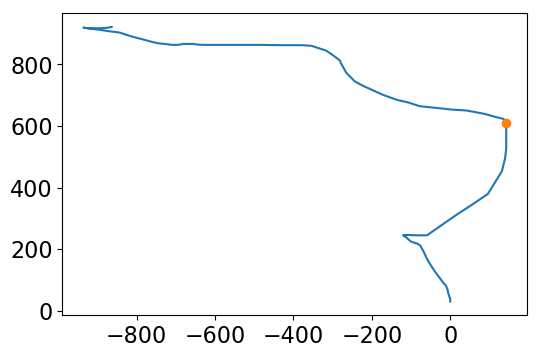

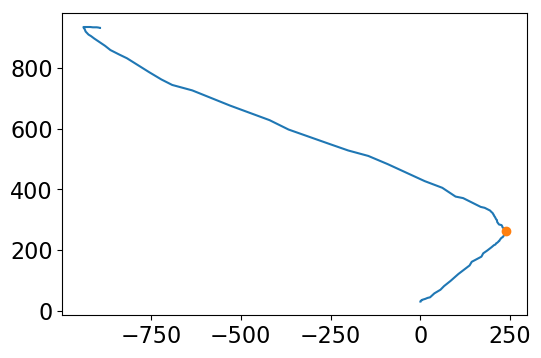

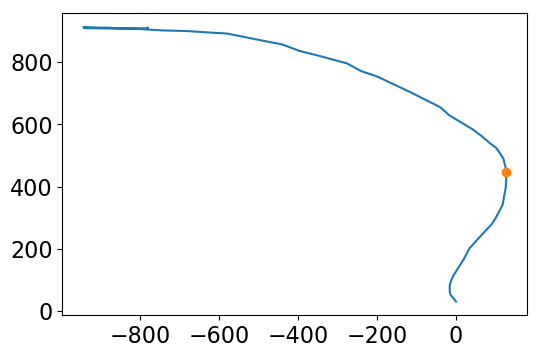

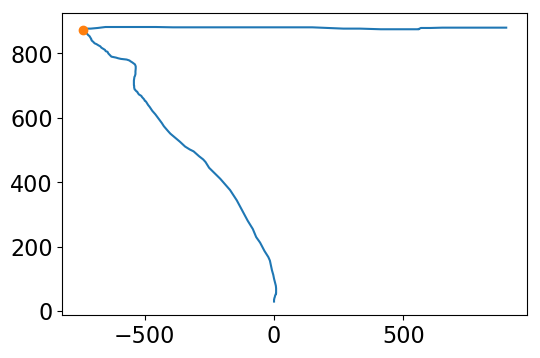

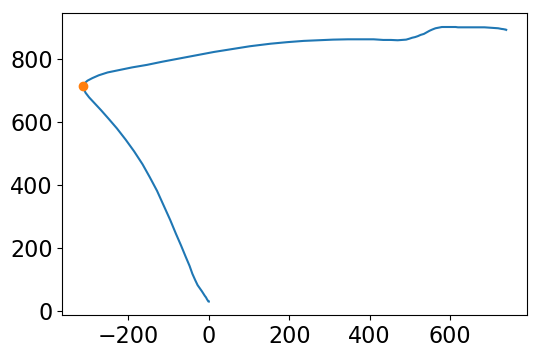

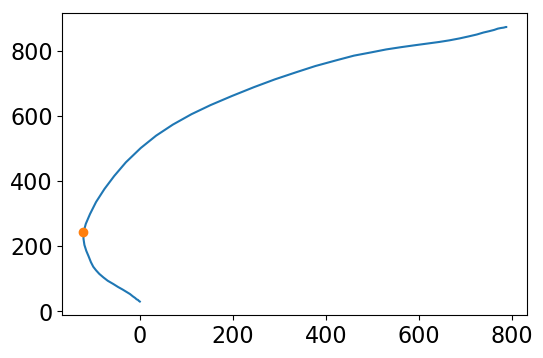

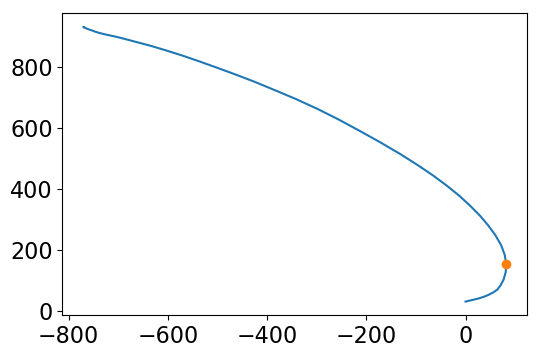

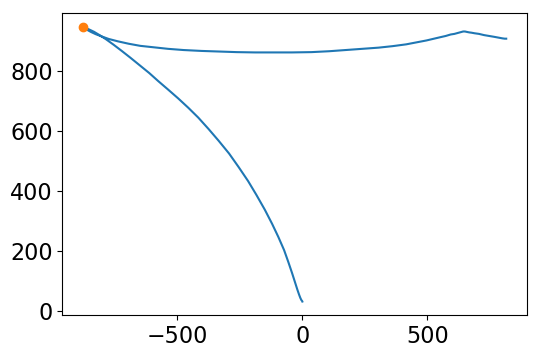

In [3]:
def plot_com_examples(choices, dynamics):
    for i in range(1,5):
        trial = random.sample(list(choices.index), 1)    
        traj = dynamics.loc[trial]
        idx_com = int(choices.loc[trial].idx_midline_d)

        print(traj.index.unique()[0])
        plt.figure()
        plt.plot(traj.mouse_x, traj.mouse_y)
        plt.plot([traj.mouse_x.values[idx_com]], [traj.mouse_y.values[idx_com]], marker='o')

plot_com_examples(choices_1[choices_1.is_com], dynamics_1)
plot_com_examples(choices_2[choices_2.is_com], dynamics_2)

It seems that CoM detection is plausible. Now, we have t_CoM_mouse. How do we get t_CoM_eye? We'll need to find the saccade which is closest in time to t_CoM_mouse. We can have three cases. If eye_v[idx_midline_d] < threshold, then saccade is either 1) finished or 2) hasn't started yet. The other case is eye_v[idx_midline_d] > threshold, which means that 3) the saccade is ongoing, in this case we need to find the time point before t_CoM when it started.

The code below makes several simplifying assumptions to make the algorithm of lag calculation pracitcally feasible.
1. The saccade corresponding to "eye CoM" is always towards the same response area as the "mouse CoM". This is not so in several trials, so these trials should be discarded.
2. The case when the "eye CoM" saccade finishes before the moues CoM is discarded. Again, the few trials where this is observed should be discarded (or manually processed)


In [3]:
def get_com_lag_v1(trajectory):
    eye_v_threshold = 1000   
    com_idx = int(trajectory.idx_midline_d.values[0])
    t = trajectory.timestamp.values
#     eye_v = trajectory.eye_v.values

    timestep = trajectory.timestamp.values[1] - trajectory.timestamp.values[0]
    eye_v = np.diff(trajectory.eye_x)/timestep
    
    if abs(eye_v[com_idx]) < eye_v_threshold:
        # if the eye 'does not move' at the time of CoM, then find the closest point at which 
        # eye_vx exceeded the threshold
#         saccade_after = np.argmax(abs(eye_v[com_idx:]) > eye_v_threshold)
#         saccade_before = com_idx - np.argmax(abs(eye_v[:com_idx][::-1]) > eye_v_threshold)
        saccade_idx = com_idx + np.argmax(abs(eye_v[com_idx:]) > eye_v_threshold)
#        TODO: maybe we should also look to the left? In case the eye already finished moving when
#        the hand started to move
    else:
        '''
        if the saccade is ongoing at the time of CoM, then find the closest point  (only look to 
        the left) at which eye_vx crossed the threshold from below, i.e., <1000 changed to >1000
        '''
        if len(np.where((abs(eye_v[:com_idx]) < eye_v_threshold) == True)[0])==0:
            print(trajectory)
        saccade_idx = np.where((abs(eye_v[:com_idx]) < eye_v_threshold) == True)[0][-1]
    lag = (t[com_idx] - t[saccade_idx])
    return pd.Series({'idx_com_saccade': saccade_idx,
                      't_com': t[com_idx],
                      't_com_saccade': t[saccade_idx], 
                      'com_lag':lag})

def append_com_lag(choices, dynamics):
    dynamics = dynamics.join(choices.idx_midline_d)
    return choices.join(dynamics[choices.is_com].groupby(level=index).apply(get_com_lag_v1))

In [26]:
choices_1 = append_com_lag(choices_1, dynamics_1)
choices_2 = append_com_lag(choices_2, dynamics_2)

(269, 3, 3, 57)
(451, 4, 10, 48)
(451, 4, 7, 30)
(269, 1, 6, 42)
(269, 4, 4, 57)
(391, 2, 9, 45)
(391, 3, 6, 17)
(391, 1, 5, 31)
(269, 4, 1, 33)
(451, 4, 10, 48)
(269, 1, 4, 5)
(391, 2, 2, 49)
(391, 1, 6, 48)
(451, 2, 9, 23)
(269, 2, 8, 25)
(269, 2, 10, 19)
(391, 2, 4, 15)
(269, 2, 1, 27)
(451, 4, 3, 30)
(391, 4, 1, 47)
(269, 4, 1, 42)
(391, 3, 10, 7)
(391, 2, 4, 39)
(269, 4, 2, 20)
(391, 2, 8, 3)
(391, 4, 9, 11)
(269, 3, 4, 45)
(391, 2, 4, 34)
(391, 3, 7, 44)
(269, 3, 3, 2)
(391, 3, 3, 20)
(269, 1, 10, 20)
(275, 2, 7, 51)
(451, 4, 3, 30)
(391, 3, 9, 4)
(391, 4, 2, 9)
(391, 4, 4, 55)
(391, 4, 9, 45)
(451, 3, 10, 51)
(269, 2, 4, 24)
(391, 2, 5, 60)
(391, 3, 6, 17)
(275, 2, 7, 51)
(391, 3, 5, 52)
(391, 1, 1, 34)
(391, 2, 7, 34)
(391, 3, 10, 33)
(391, 4, 1, 47)
(391, 1, 1, 11)
(391, 3, 2, 46)
(166, 4, 1, 5)
(518, 3, 3, 54)
(166, 1, 9, 17)
(624, 3, 4, 47)
(166, 1, 6, 52)
(624, 2, 3, 29)
(166, 1, 5, 14)
(624, 3, 4, 47)
(624, 3, 6, 52)
(166, 2, 7, 2)
(166, 2, 8, 49)
(624, 2, 1, 26)
(518, 1, 

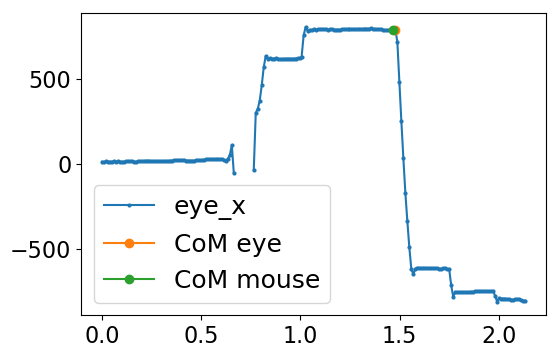

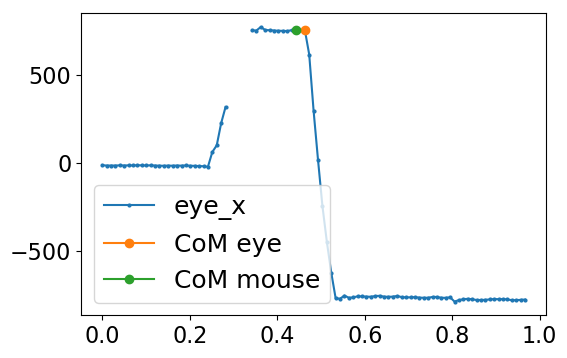

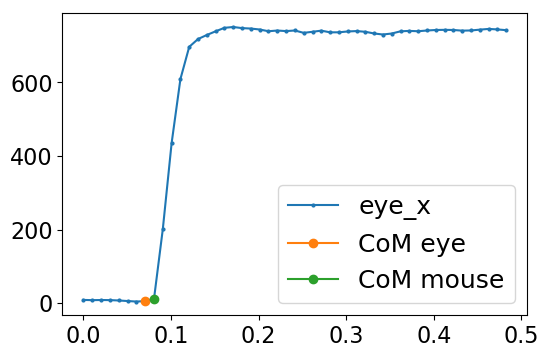

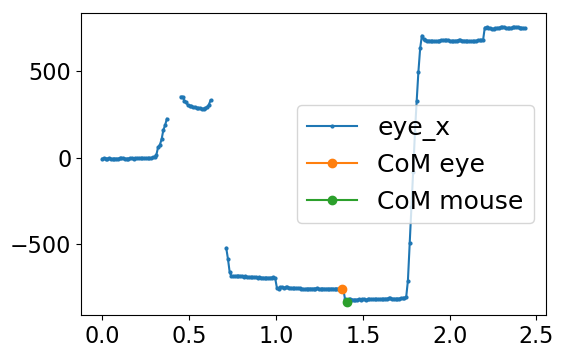

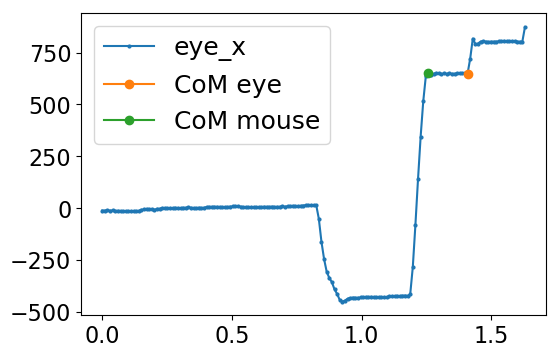

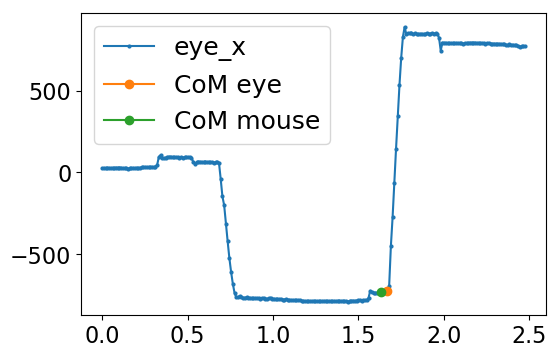

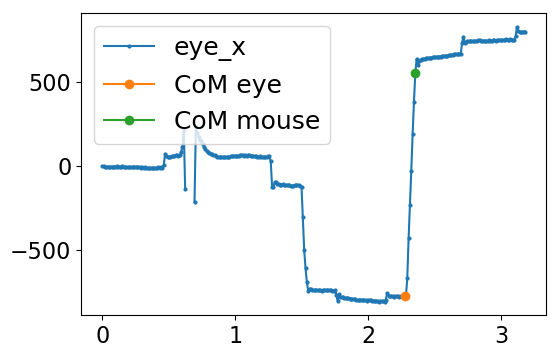

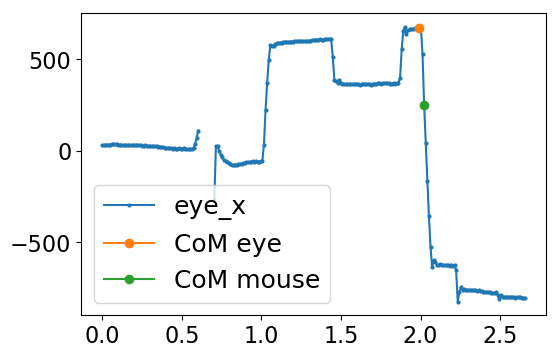

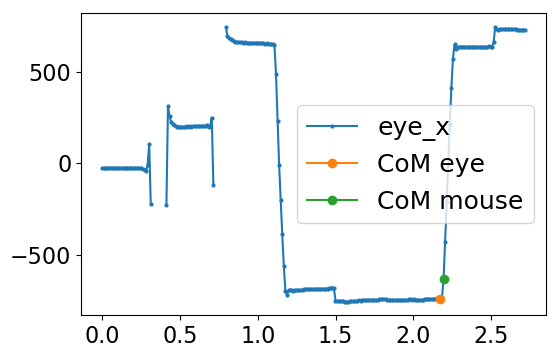

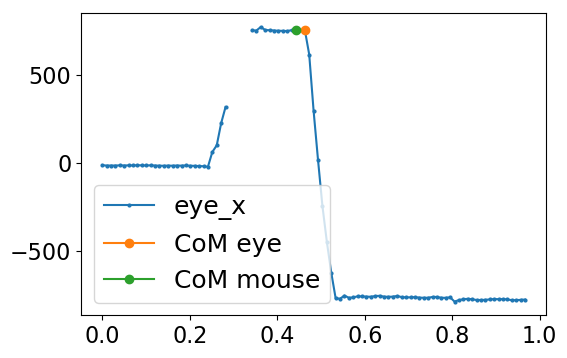

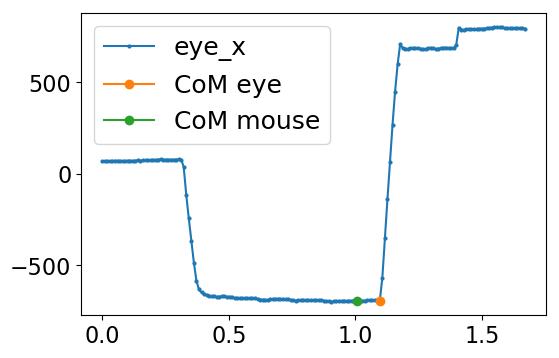

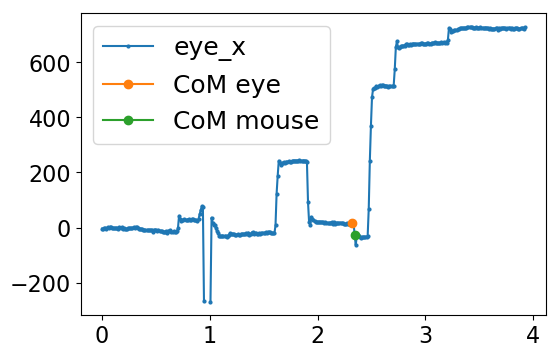

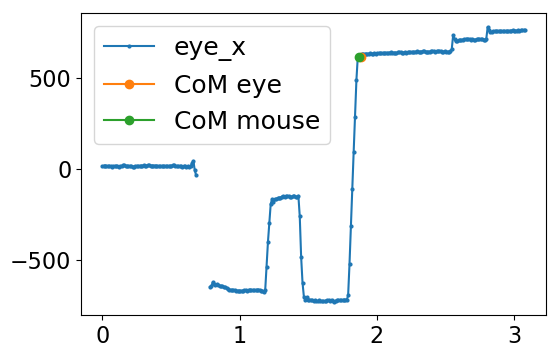

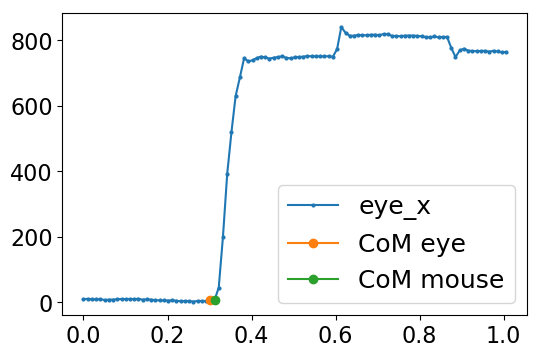

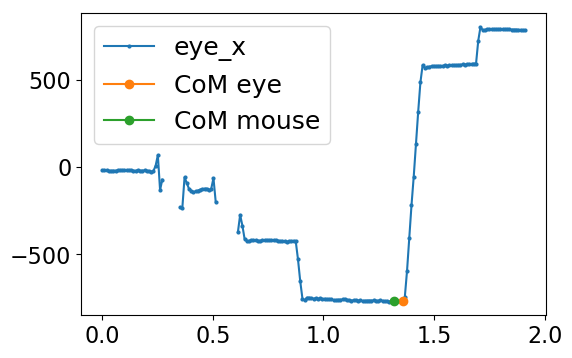

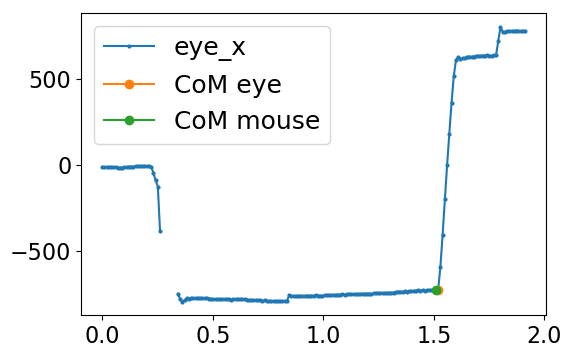

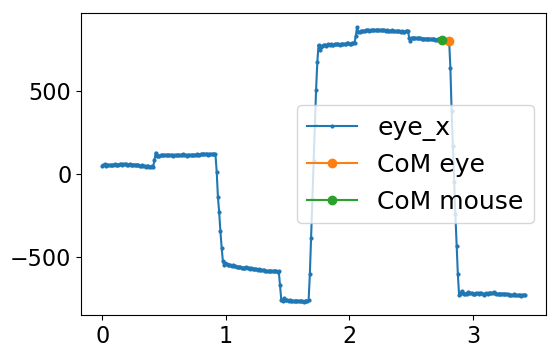

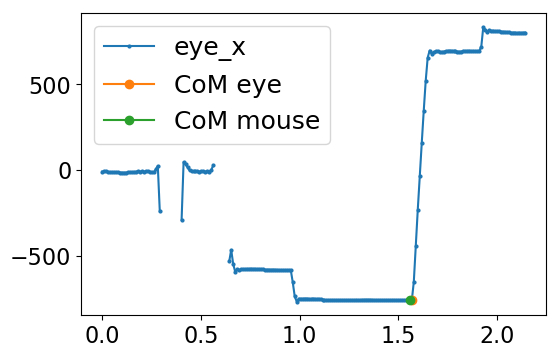

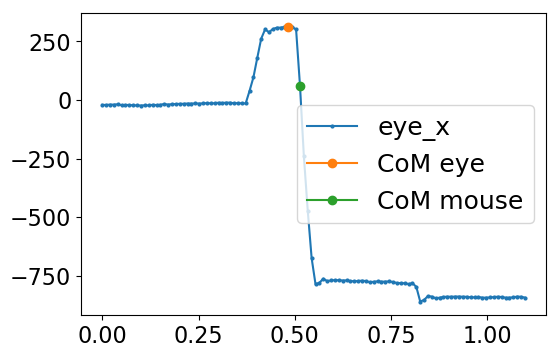

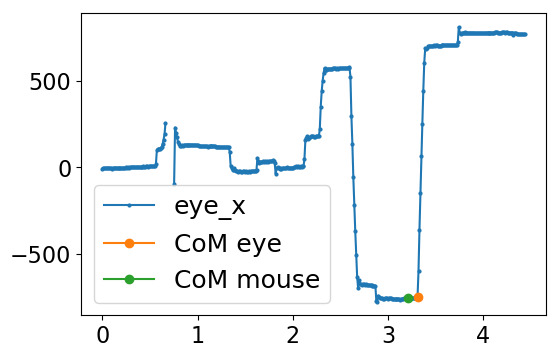

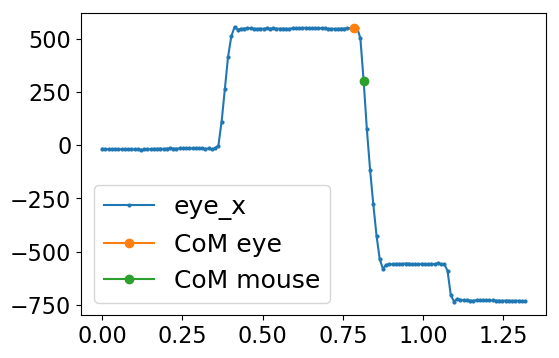

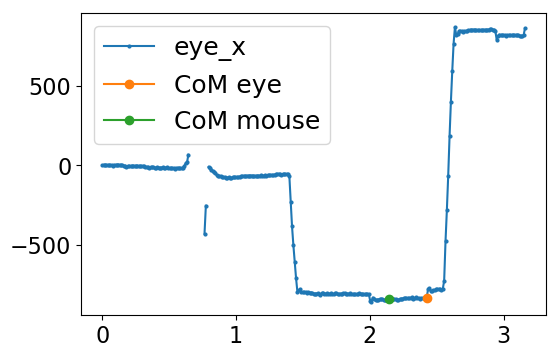

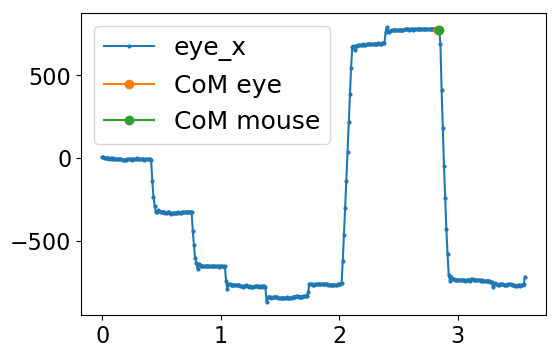

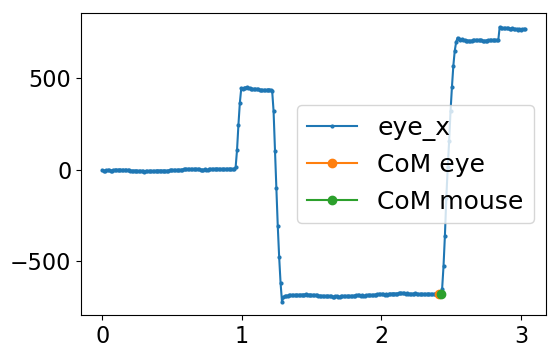

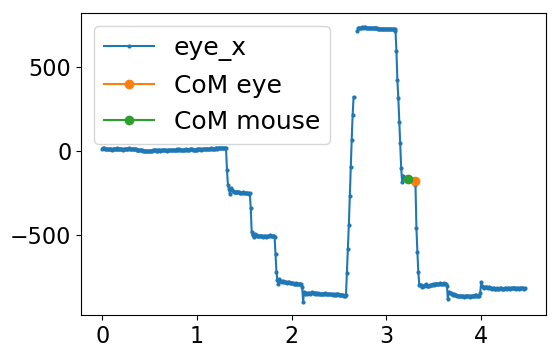

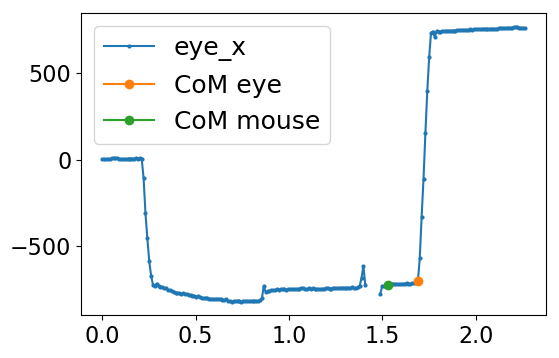

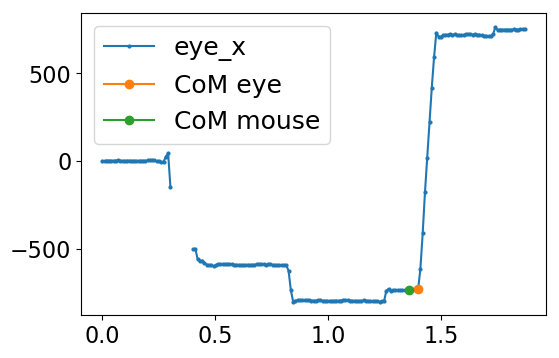

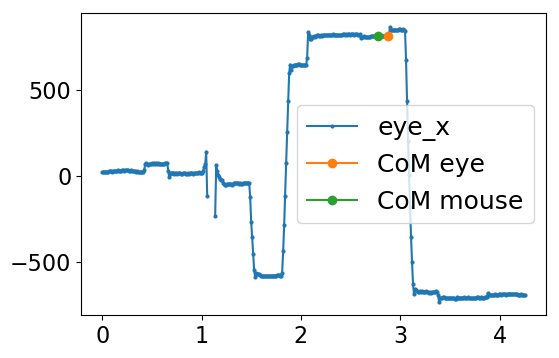

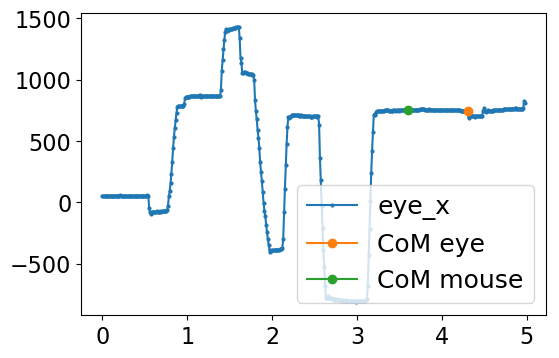

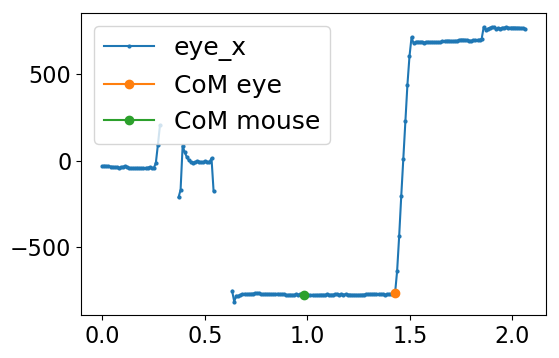

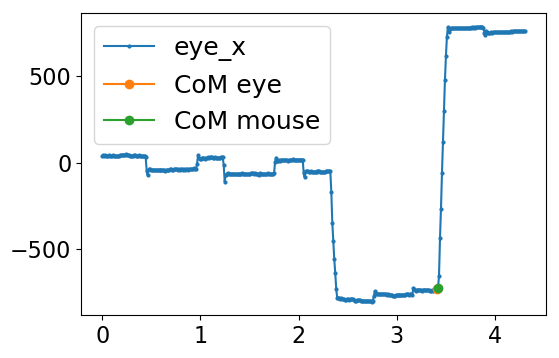

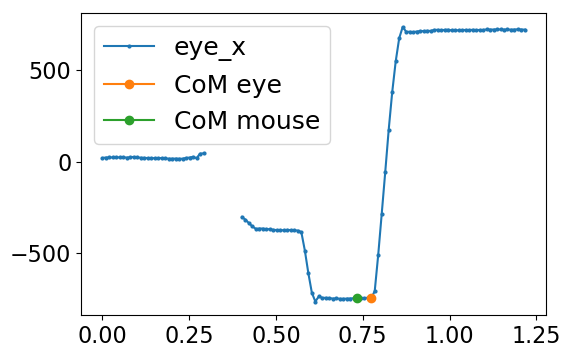

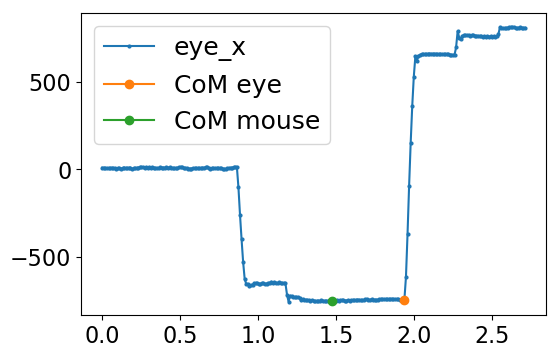

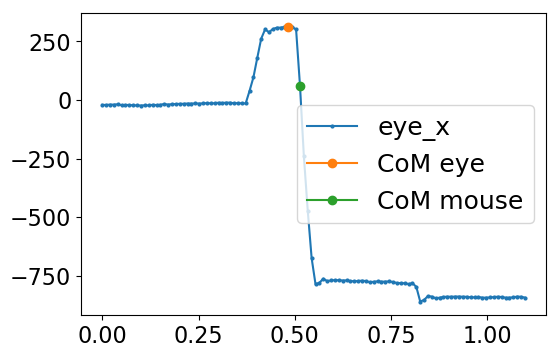

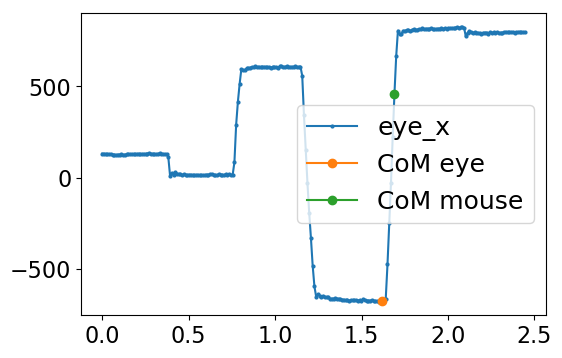

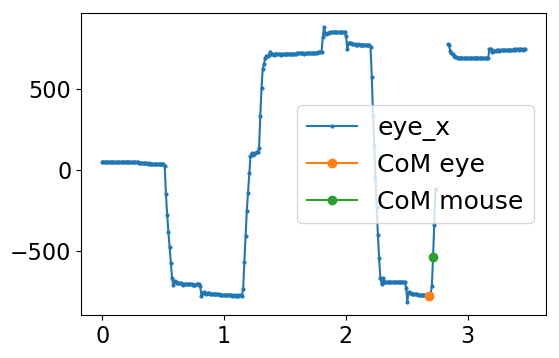

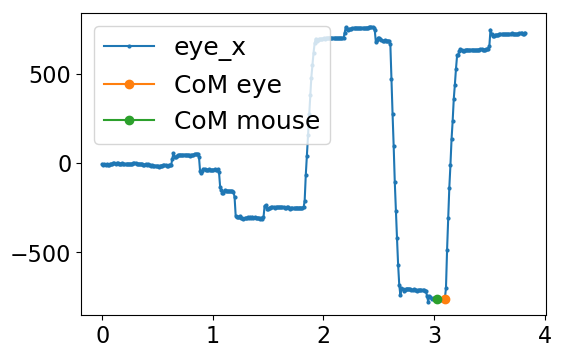

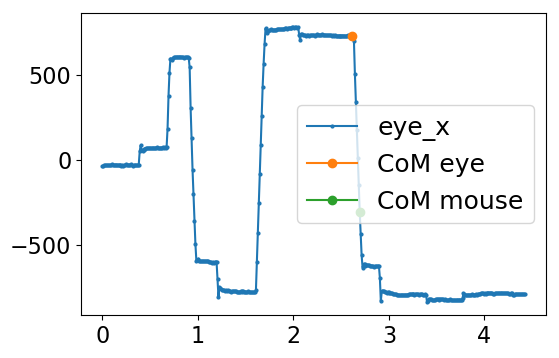

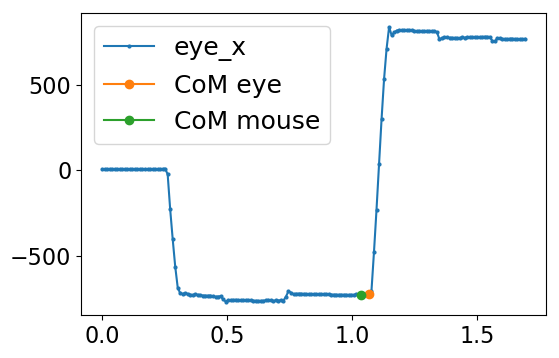

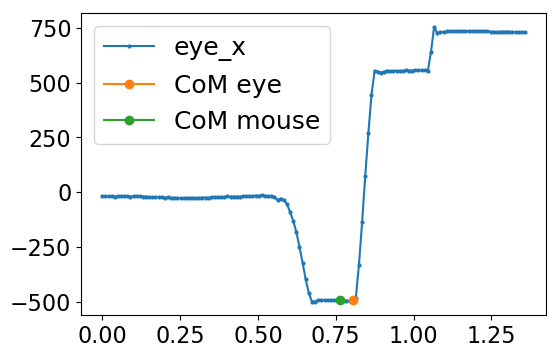

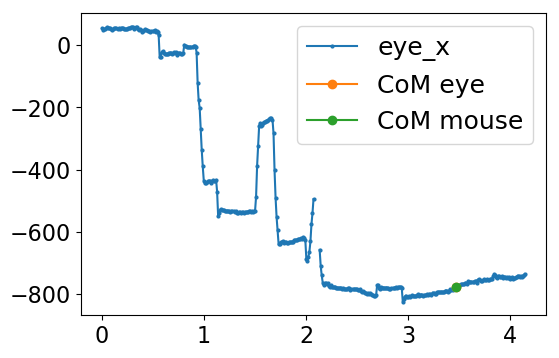

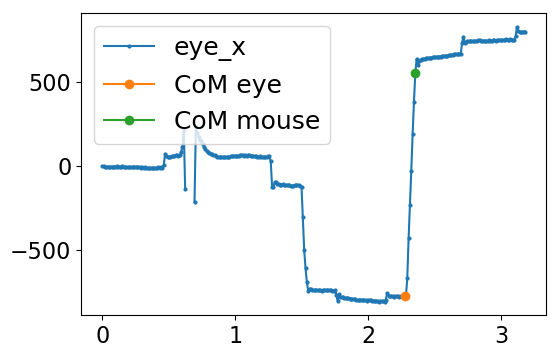

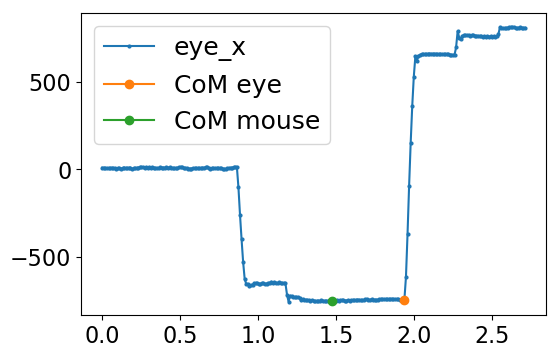

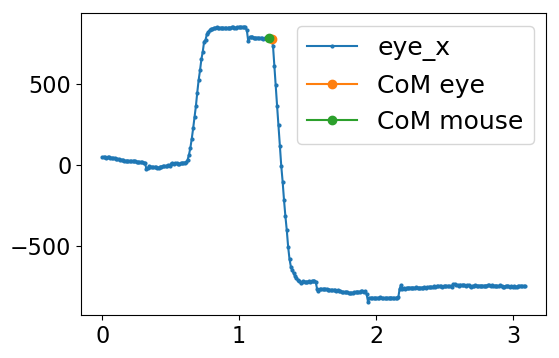

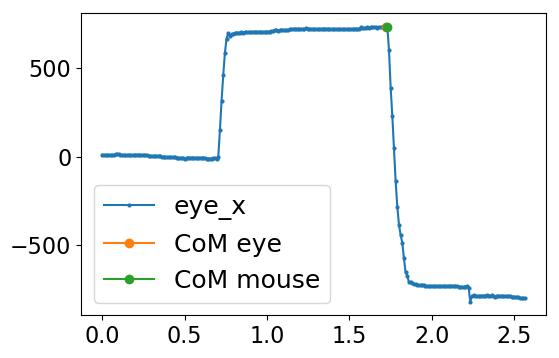

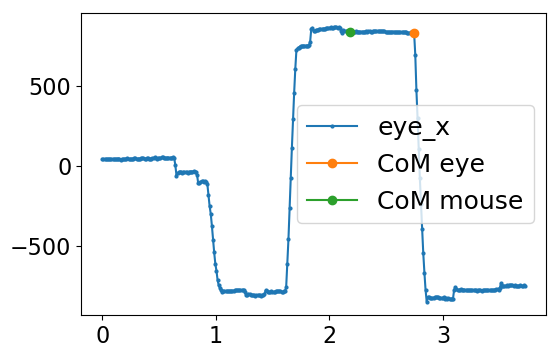

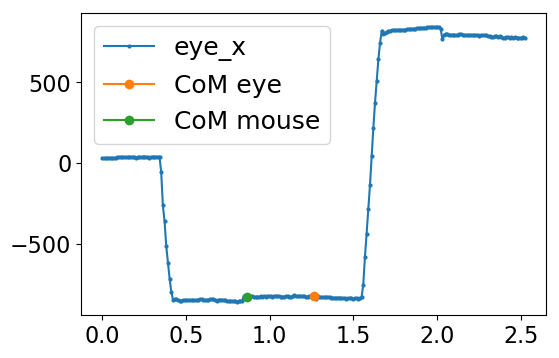

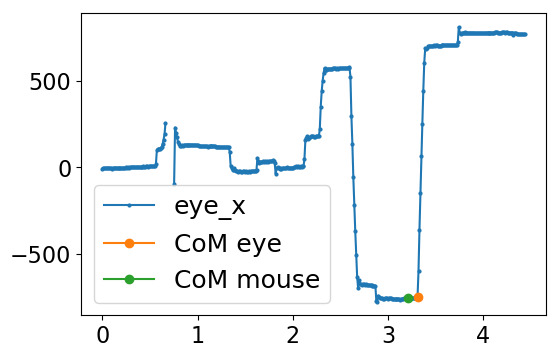

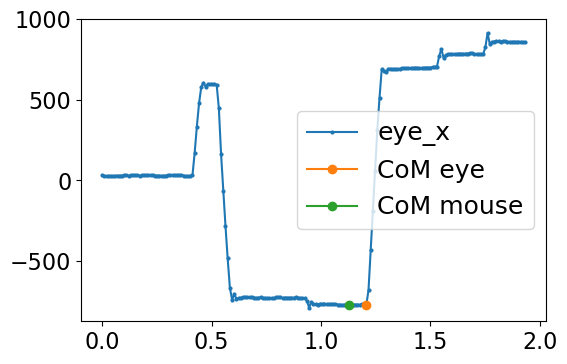

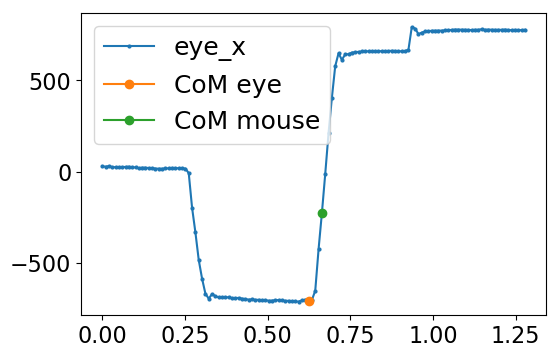

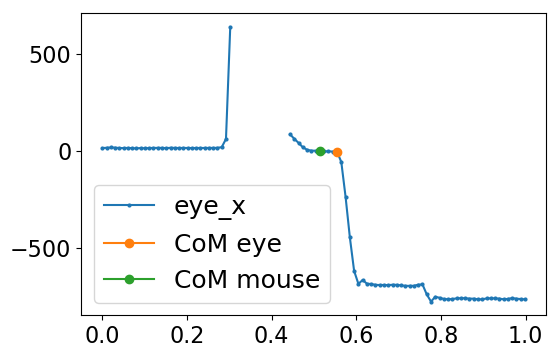

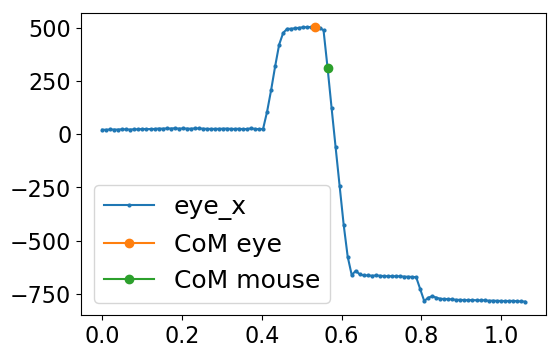

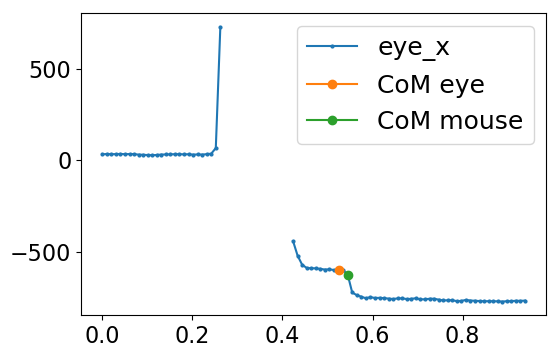

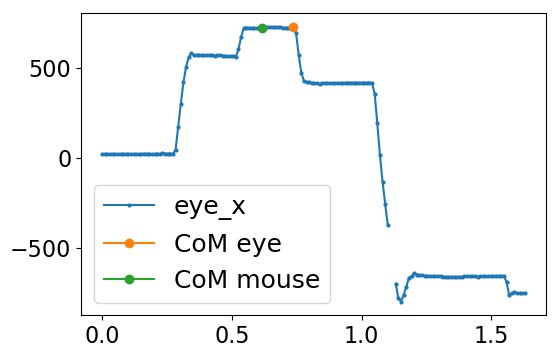

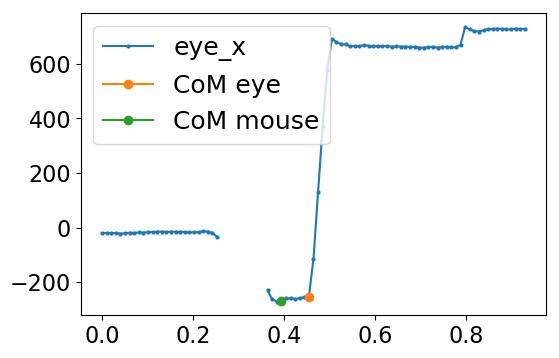

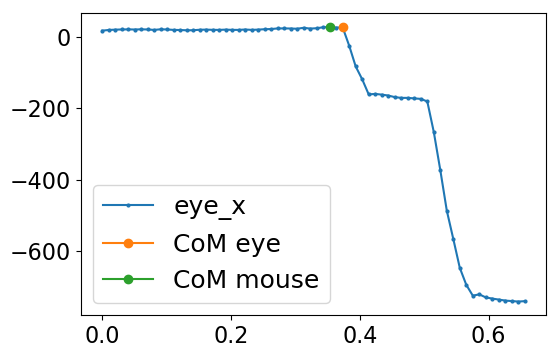

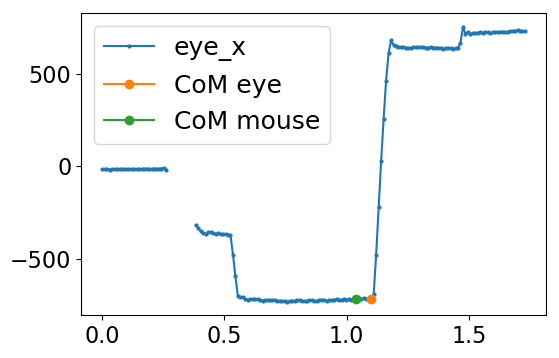

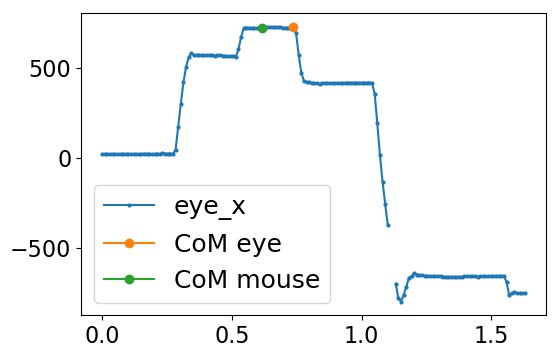

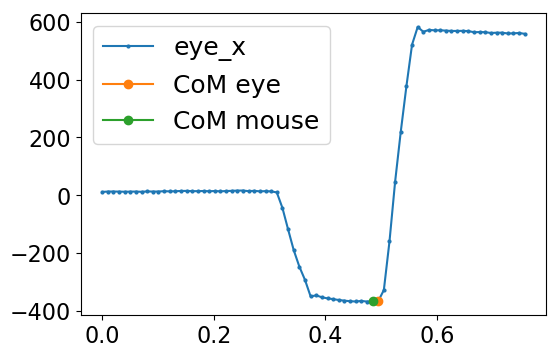

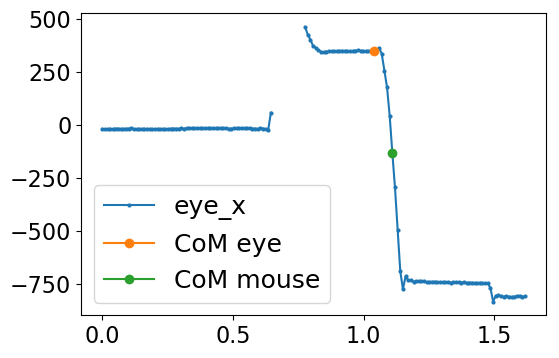

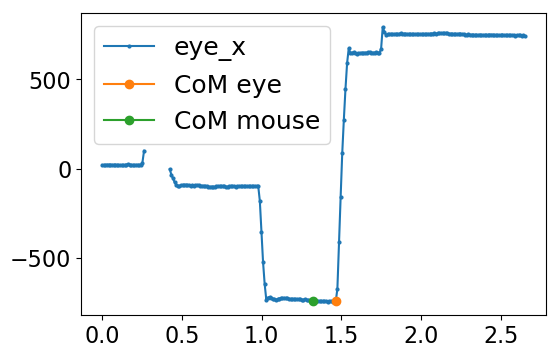

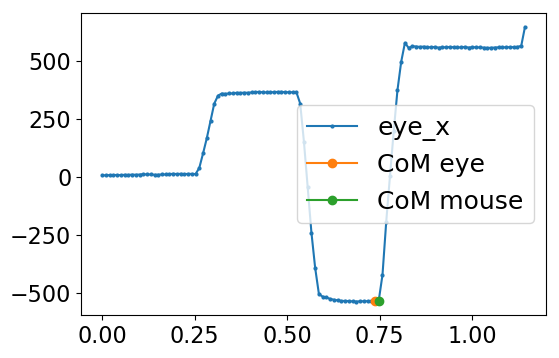

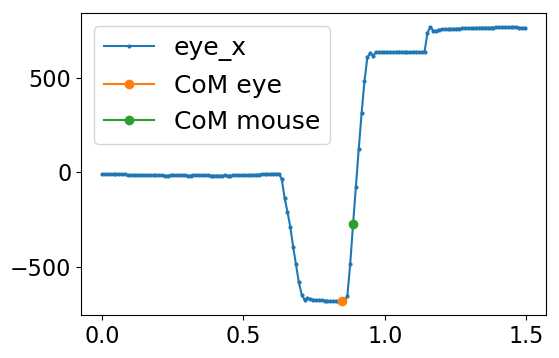

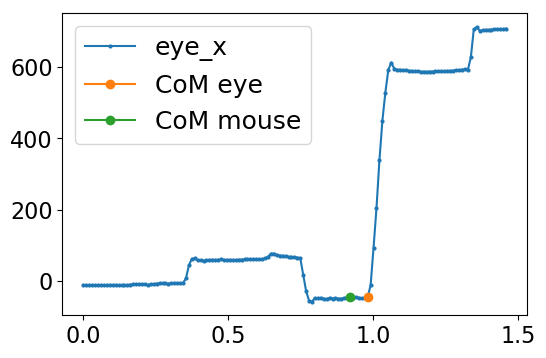

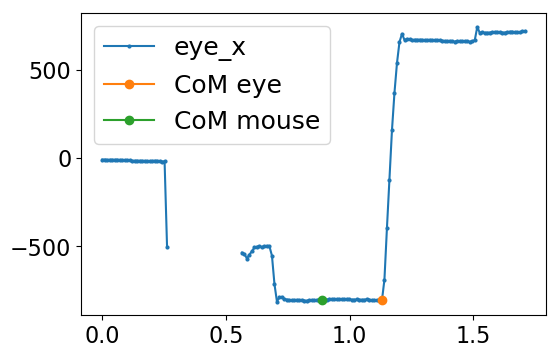

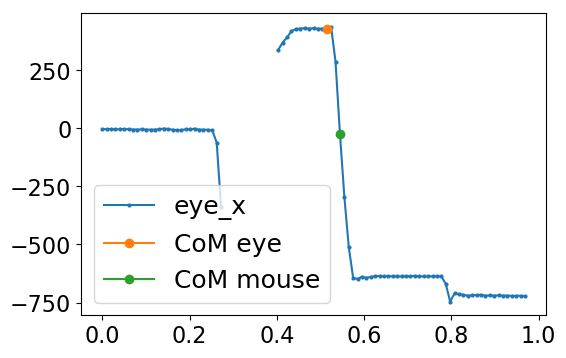

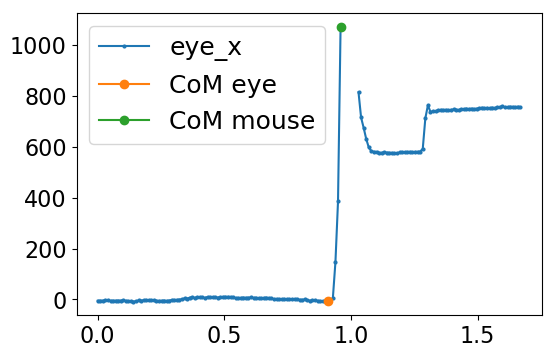

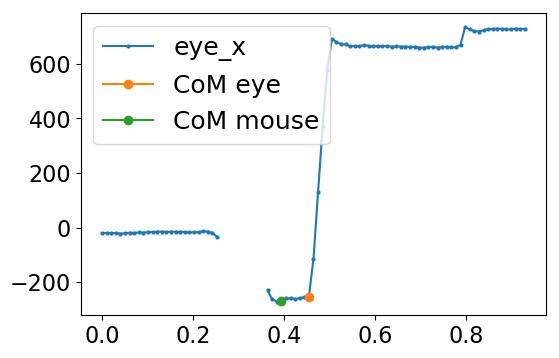

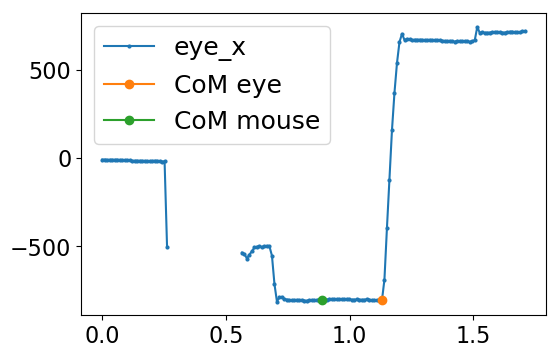

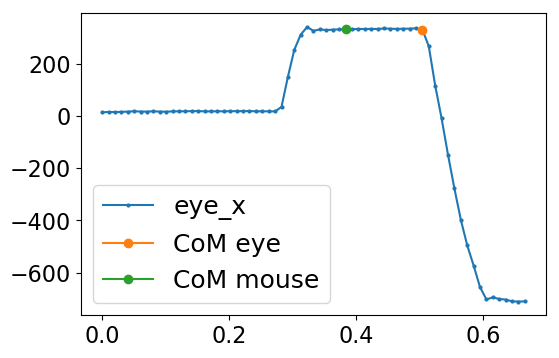

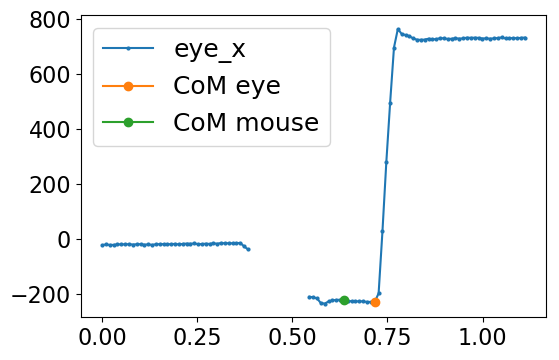

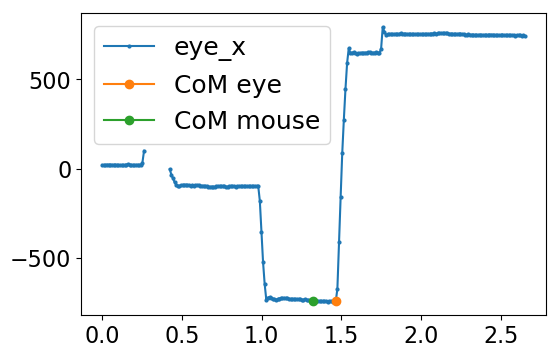

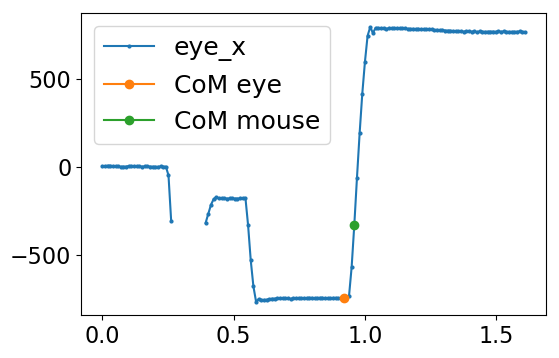

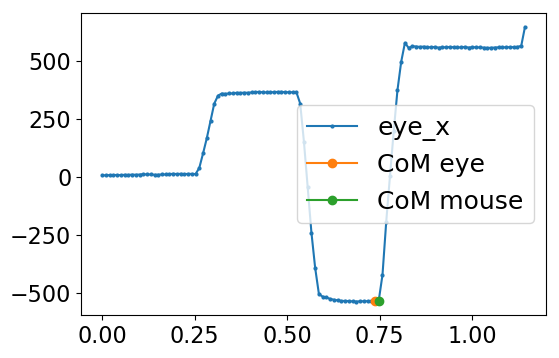

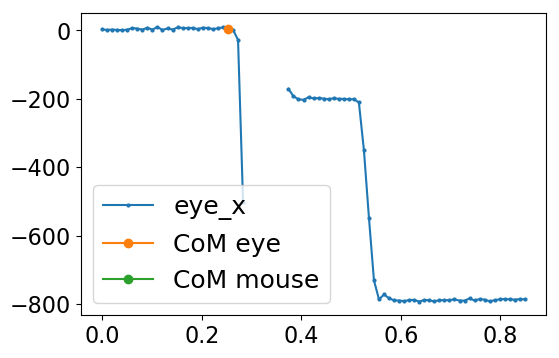

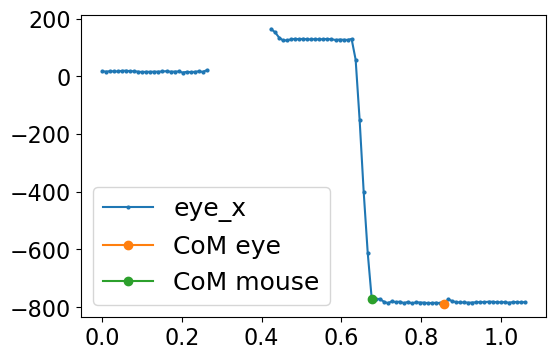

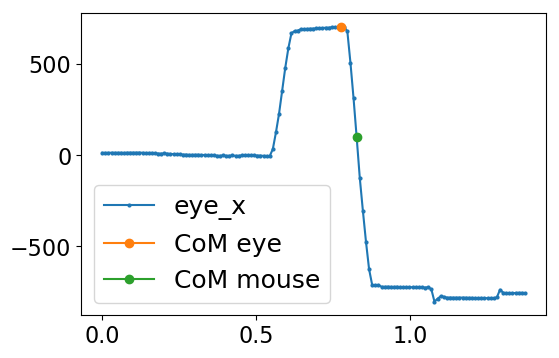

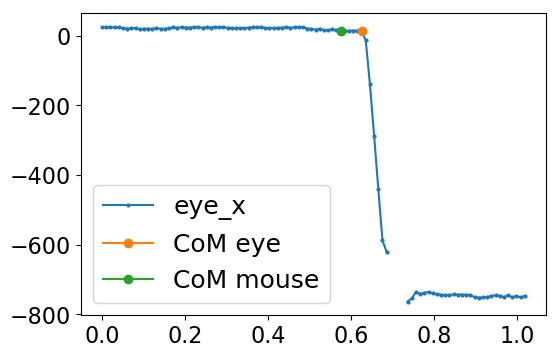

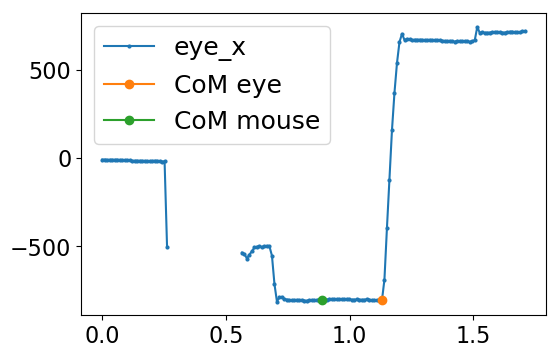

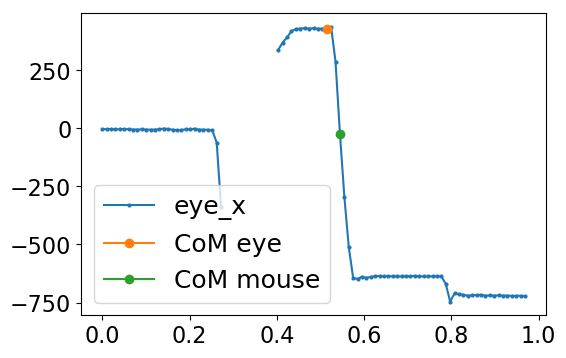

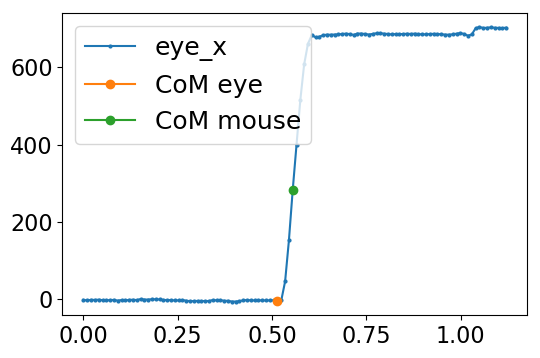

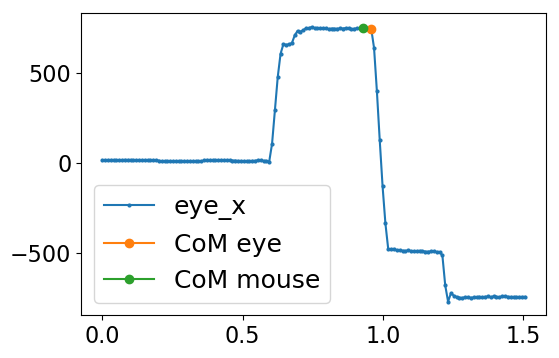

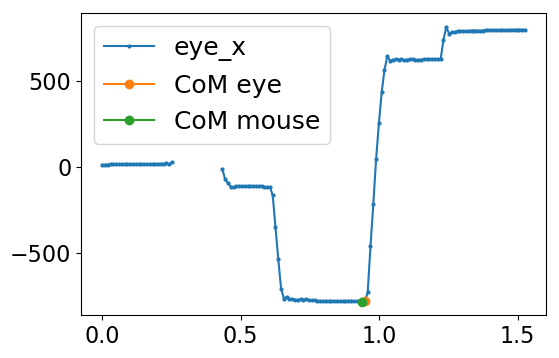

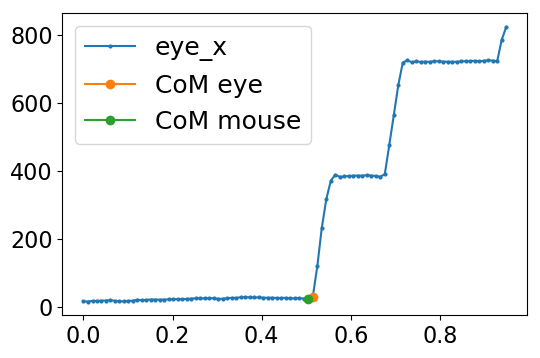

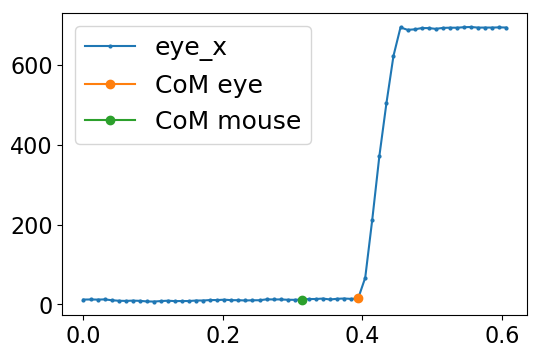

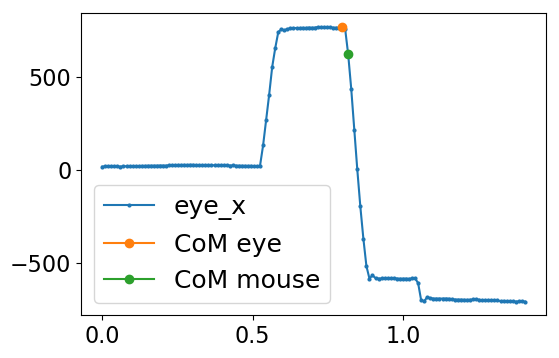

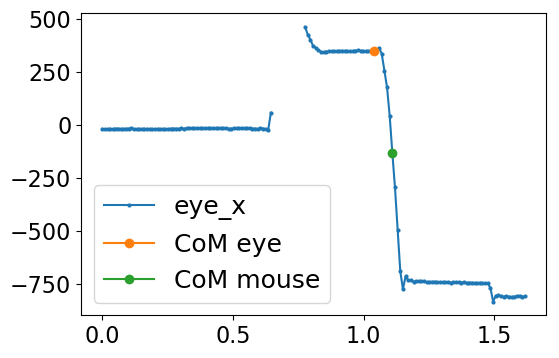

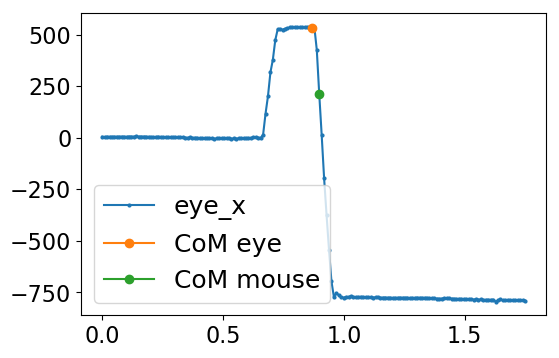

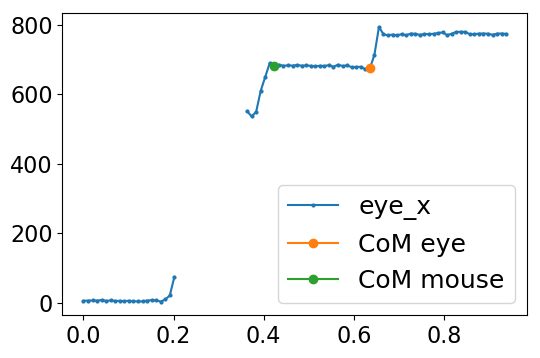

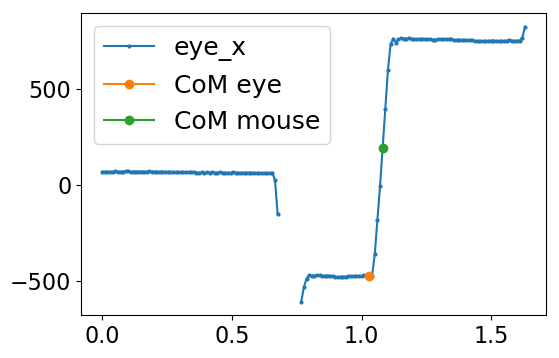

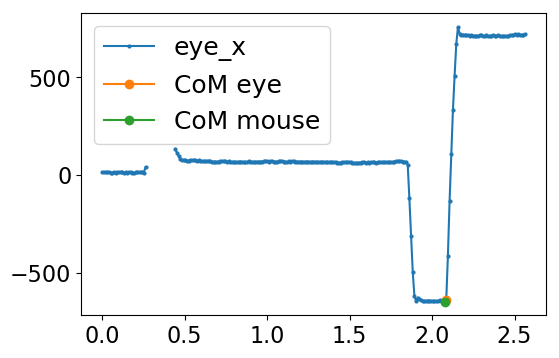

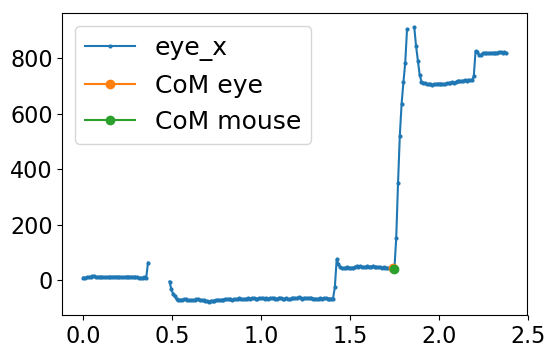

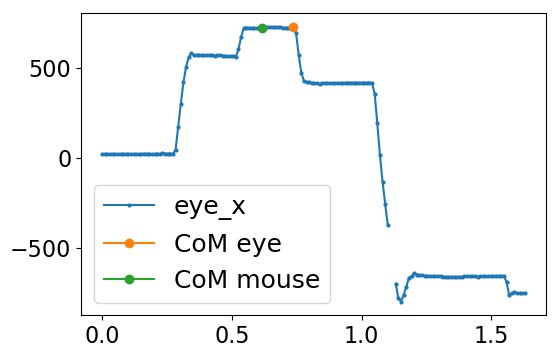

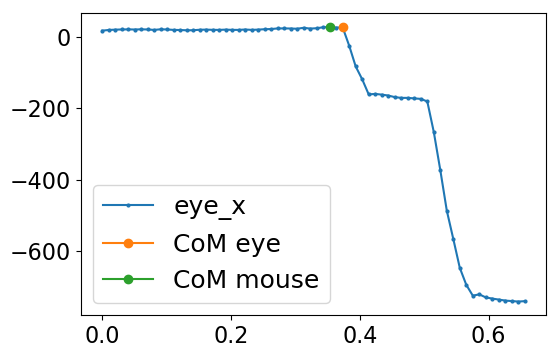

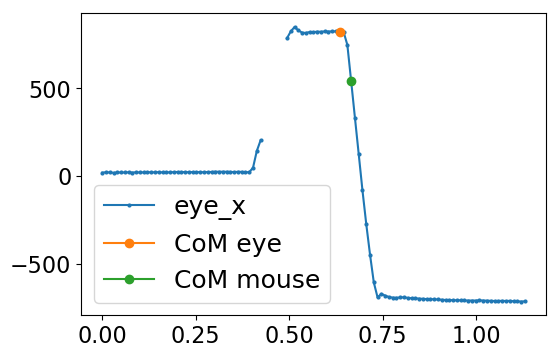

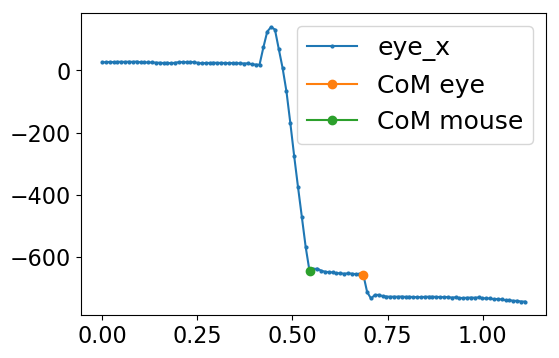

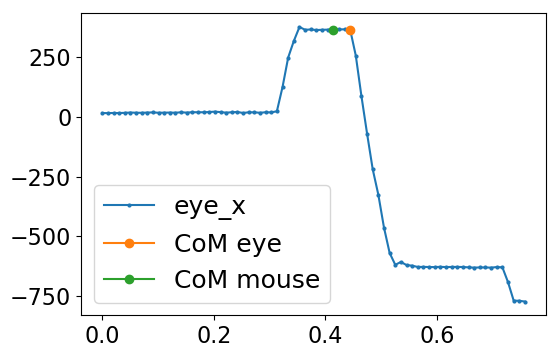

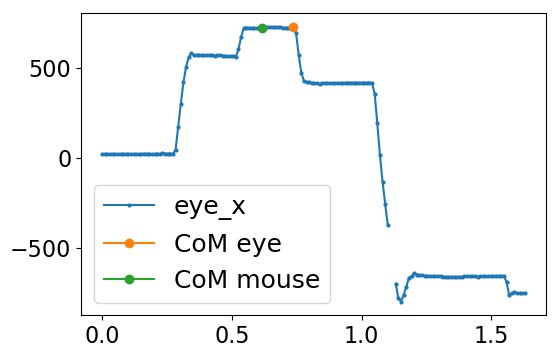

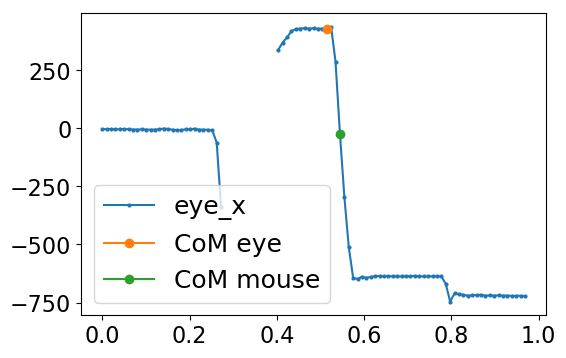

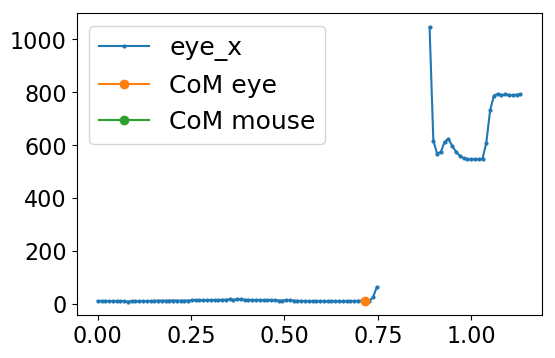

In [28]:
def plot_var_vs_t(trial_id, choices, dynamics, var):
    trial = choices.loc[trial_id]
    traj = dynamics.loc[trial_id]    

    print(traj.index.unique()[0])
    plt.figure()
    plt.plot(traj['timestamp'], traj[var], label=var, marker='o', ms=2, ls='-')
    idx_saccade = int(trial.idx_com_saccade)
    idx_com = int(trial.idx_midline_d)
    plt.plot([traj.timestamp.values[idx_saccade]], [traj[var].values[idx_saccade]], marker='o', label='CoM eye')
    plt.plot([traj.timestamp.values[idx_com]], [traj[var].values[idx_com]], marker='o', label='CoM mouse')
    plt.legend()
    
def plot_example_lags(choices, dynamics):
    for i in range(1,5):
        trial_id = random.sample(list(choices.index), 1)
        plot_var_vs_t(trial_id, choices, dynamics, var='eye_x')

def save_example_coms(choices, dynamics):
    for i in range(1,51):
        trial_id = random.sample(list(choices.index), 1)
        plot_var_vs_t(trial_id, choices, dynamics, var='eye_x')
        plt.savefig('figures\com\\'+str(trial_id[0]))

save_example_coms(choices_1[choices_1.is_com], dynamics_1)
save_example_coms(choices_2[choices_2.is_com], dynamics_2)
        
# plot_example_lags(choices_1[choices_1.is_com], dynamics_1)
# plot_example_lags(choices_2[choices_2.is_com], dynamics_2)

Let's take a closer look at what exactly happens in the trajectories where the current eye CoM detection doesn't work well

Experiment 1
- (391, 1, 5, 55): 'small' saccade preceding the actual saccade. Cannot be filtered by threshold.
- (275, 4, 1, 49): poor mouse CoM detection (mouse stays on response area for 500 ms, not the last point in )
- (391, 3, 9, 57): messy mouse data: small movements toward new target, t_midline_d doesn't work
- (275, 1, 9, 10): actual saccade finishes before CoM, then algo finds the next saccade, which is a small adjustment within response are
- (391, 1, 6, 22): threshold too low

Experiment 2
- (166, 2, 10, 23): eye movement towards the target consists of two saccades, the second one is detected
- (166, 2, 4, 5): threshold (300) too low
- (166, 4, 1, 5): everything's ok, earlier 'movement' is actually a blink
- (624, 1, 8, 44): eye doesn't move throughout the trial

Three strategies to deal with this:
1. Leave the automatically detected CoMs as is. This would bias the lag statistics, but how significantly?
2. Exclude these trials at all (if not too many). For this, need to go through all CoMs (539 in two exps), compile a list of problematic ones.
3. Replace the automatically detected CoMs with manual input. For this, need to come up with a way to input precise t(CoM) by hand. We can do this if asked by the reviewers.



(166, 1, 2, 21)
(166, 1, 2, 21)
(166, 1, 2, 21)
(166, 1, 2, 21)


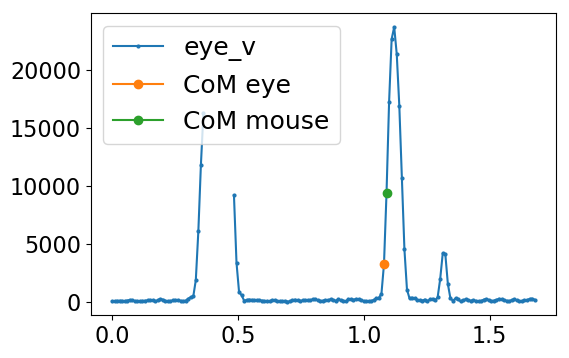

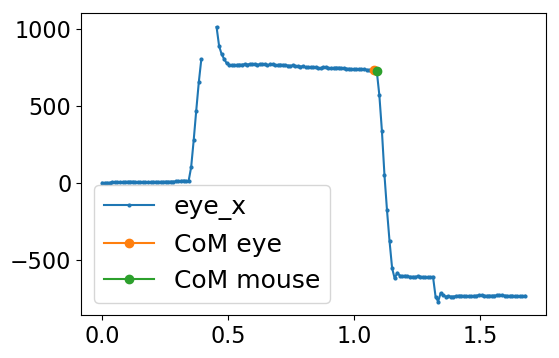

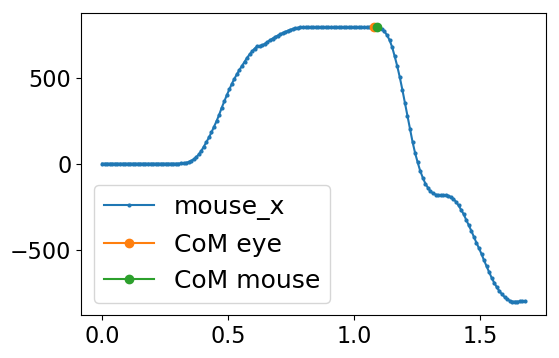

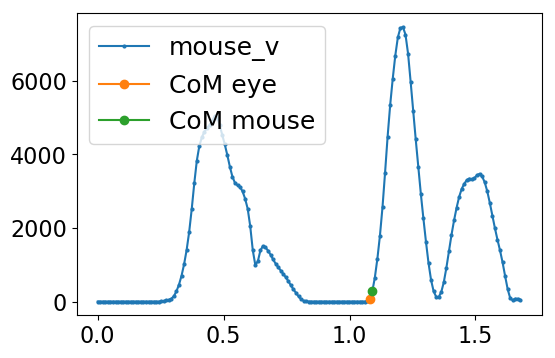

In [27]:
exp = exp_2
choices, dynamics = (choices_1, dynamics_1) if exp == exp_1 else (choices_2, dynamics_2)
trial = (166, 1, 2, 21)

plot_var_vs_t(trial, choices, dynamics, var='eye_v')
plot_var_vs_t(trial, choices, dynamics, var='eye_x')
plot_var_vs_t(trial, choices, dynamics, var='mouse_x')
plot_var_vs_t(trial, choices, dynamics, var='mouse_v')

""


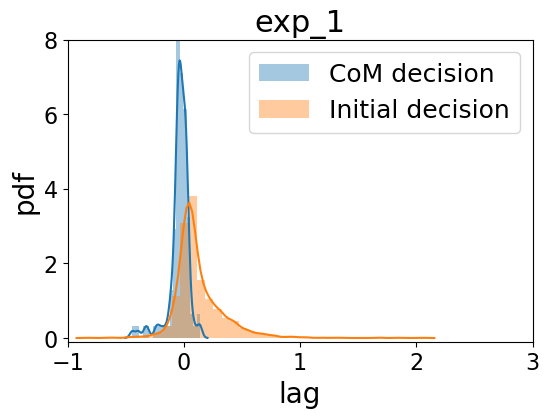

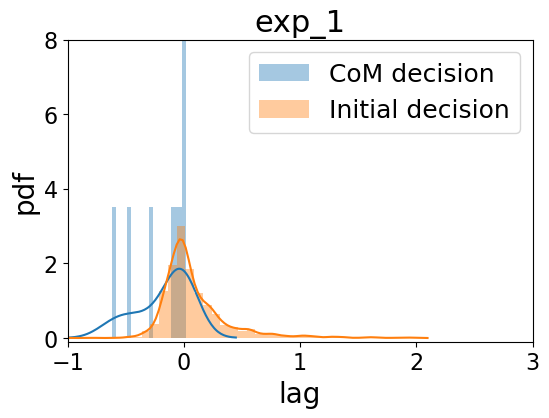

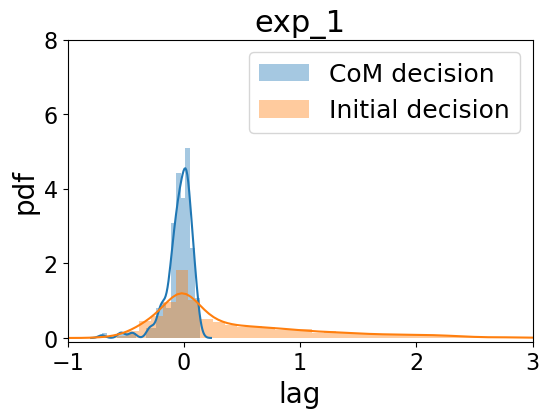

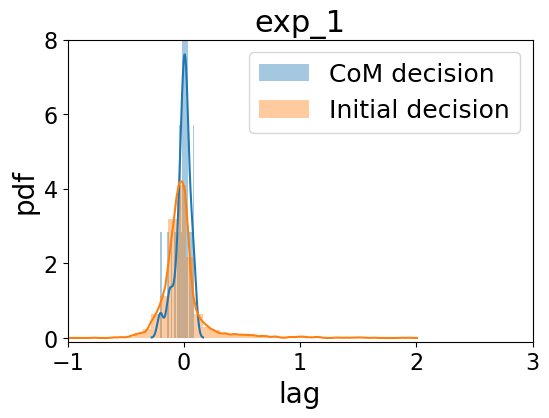

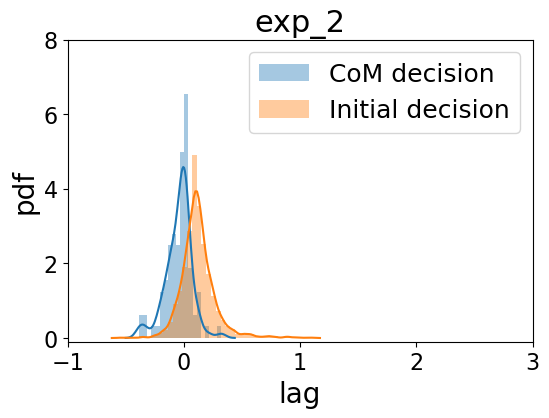

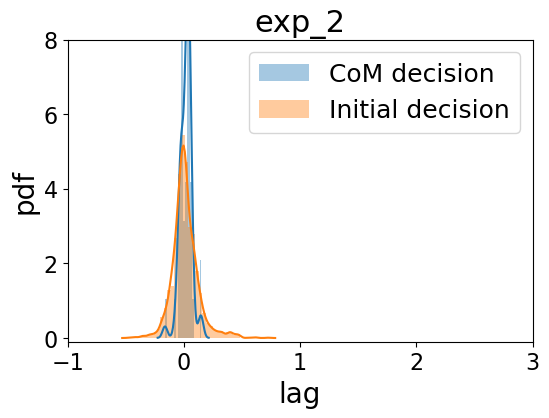

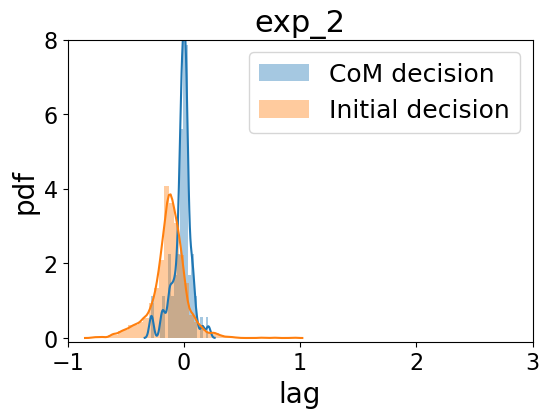

In [89]:
def plot_ID_com_lag_dist(choices, exp):
    plt.figure()
    choices_com = choices[choices.is_com]
    ax = sns.distplot(choices_com[~np.isnan(choices.com_lag)].com_lag, label='CoM decision', bins=20)
    ax = sns.distplot(choices[~np.isinf(choices.ID_lag)].ID_lag, label='Initial decision', bins=40, ax=ax)    
    ax.set_xlim((-1,3))
    ax.set_ylim((-0.1,8))
    ax.set_xlabel('lag')
    ax.set_ylabel('pdf')
    plt.title(exp)
    plt.legend()
# plot_ID_com_lag_dist(choices_1, exp_1)
# plot_ID_com_lag_dist(choices_2, exp_2)
choices_1.groupby('subj_id').apply(lambda c: plot_ID_com_lag_dist(c, exp_1))
choices_2.groupby('subj_id').apply(lambda c: plot_ID_com_lag_dist(c, exp_2))

In [71]:
from scipy.stats import ttest_ind

def pooled_sd(s1, s2):
    return np.sqrt(((len(s1)-1)*s1.var()+(len(s2)-1)*s2.var())/(len(s1)+len(s2)-2))

def lag_ID_CoM_ttest(choices):
#    data = choices[choices.coherence == coherence]
    t, p = ttest_ind(choices.ID_lag[((choices.ID_lag.notnull()) & (~np.isinf(choices.ID_lag)))], 
                    choices.com_lag[choices.com_lag.notnull()], equal_var=False)
    return (t, p)

def print_lag_ttest_results(choices, exp):
    s1 = choices.ID_lag[((choices.ID_lag.notnull()) & (~np.isinf(choices.ID_lag)))]
    s2 = choices.com_lag[choices.com_lag.notnull()]
    d = (s1.mean() - s2.mean())/pooled_sd(s1, s2)
    print(exp)
    print('Subjects: %s' % str(choices.subj_id.unique()))
    print('Cohen\'s d: %f' % (d))
    print("Welch's unequal variances t-test:" + str(lag_ID_CoM_ttest(choices)))
    print('')

# print_lag_ttest_results(choices_1, exp_1)
# print_lag_ttest_results(choices_2, exp_2)

choices_1.groupby('subj_id').apply(lambda c: print_lag_ttest_results(c, exp_1))
choices_2.groupby('subj_id').apply(lambda c: print_lag_ttest_results(c, exp_2))

exp_1
Subjects: [269]
Cohen's d: 0.702169
Welch's unequal variances t-test:(14.335684346009044, 2.9690485484811499e-30)

exp_1
Subjects: [275]
Cohen's d: 0.867987
Welch's unequal variances t-test:(3.3771410036785134, 0.0095044552192107071)

exp_1
Subjects: [391]
Cohen's d: 0.635866
Welch's unequal variances t-test:(20.963424518220929, 4.6826481565613866e-74)

exp_1
Subjects: [451]
Cohen's d: -0.158196
Welch's unequal variances t-test:(-2.0711458578424473, 0.048135507251757199)

exp_2
Subjects: [166]
Cohen's d: 0.861216
Welch's unequal variances t-test:(8.3465397903709366, 4.7455116013699773e-13)

exp_2
Subjects: [518]
Cohen's d: -0.161951
Welch's unequal variances t-test:(-2.8530304343346269, 0.0055166611307169051)

exp_2
Subjects: [624]
Cohen's d: -0.869461
Welch's unequal variances t-test:(-10.859604296627431, 1.483392367792811e-17)



""


In [ ]:
# choices_1.groupby('subj_id').apply(lambda c: c[c.is_com].count())

-0.04235058144172695 -0.017053366851440183
-0.70436971822 -0.383808992513
-0.03841071434410222


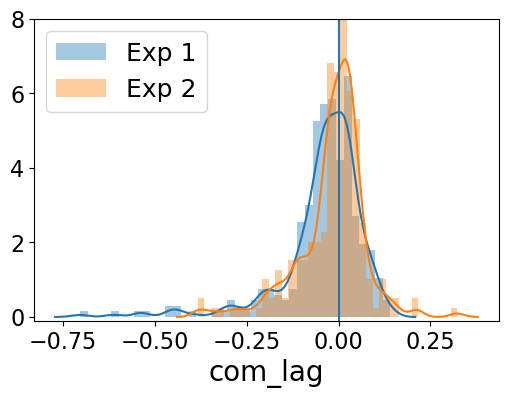

In [91]:
ax = sns.distplot(choices_1[~np.isnan(choices_1.com_lag)].com_lag, label='Exp 1', bins=40)
ax = sns.distplot(choices_2[~np.isnan(choices_2.com_lag)].com_lag, label='Exp 2', bins=40, ax=ax)
ax.set_ylim((-0.1, 8))
plt.axvline(0.0)
plt.legend()

print(choices_1.com_lag.mean(), choices_2.com_lag.mean())
print(choices_1.com_lag.min(), choices_2.com_lag.min())
print(choices_1[choices_1.com_lag>-0.6].com_lag.mean())

In [4]:
def plot_com_examples(choices, dynamics):
    for i in range(1,5):
        trial = random.sample(list(choices.index), 1)    
        traj = dynamics.loc[trial]
        idx_com = int(choices.loc[trial].idx_midline_d)

        print(traj.index.unique()[0])
        plt.figure()
        plt.plot(traj.mouse_x, traj.mouse_y)
        plt.plot([traj.mouse_x.values[idx_com]], [traj.mouse_y.values[idx_com]], marker='o')

dynamics_1.columns

Index(['timestamp', 'mouse_x', 'mouse_y', 'eye_x', 'eye_y', 'pupil_size',
       'mouse_dx', 'mouse_dy', 'eye_dx', 'eye_dy', 'mouse_vx', 'mouse_vy',
       'eye_vx', 'eye_vy', 'mouse_v', 'eye_v'],
      dtype='object')

In [103]:
def remove_nans(x):
    # number of time steps around blink to erase
    window = 10
    onsets = []
    offsets = []
    is_previous_x_nan = False
    
    # first, get onsets and offsets for each blink
    for i in range(0,len(x)):
        if np.isnan(x[i]):
            if not is_previous_x_nan:
                is_previous_x_nan = True
                onsets += [i]
            elif (i==len(x)-1):
                offsets += [i]            
        elif is_previous_x_nan:
            offsets += [i]
            is_previous_x_nan = False
            
    if len(onsets) != len(offsets):
        raise ValueError('NaN onsets and offsets do not match!')
        
    # second, for every blink, drop 10 data points (100ms) immediately before and after the blink,
    # and fill in the blanks by extrapolating from the available data points
    for i in range(0,len(onsets)):
        onset = onsets[i]
        offset = offsets[i]
        x[onset-window:offset+window] = np.NaN
        x[onset-window:int(np.floor((onset+offset)/2))] = x[onset-window-1]
        x[int(np.floor((onset+offset)/2)):offset+window] = x[offset+window+1]
    
    return x

def get_com_lag_v2(trajectory):
    eye_v_threshold = 700   
    com_idx = int(trajectory.idx_midline_d.values[0])
    t = trajectory.timestamp.values
    timestep = np.median(np.diff(trajectory.timestamp.values))
    
#     v = np.diff(remove_nans(trajectory.eye_x.values))/timestep   
#     v = remove_nans(trajectory.eye_v.values)
#     v = trajectory.eye_v.values
    v = np.diff(trajectory.eye_x.values)/timestep   
    
    onsets = []
    offsets = []
    is_previous_v_zero = True
    
    v[abs(v)<eye_v_threshold] = 0
    
    for i in range(0,len(v)):
        if v[i]!=0:
            if is_previous_v_zero:
                is_previous_v_zero = False
                onsets += [i]
            elif (i==len(v)-1):
                offsets += [i]            
        elif (not is_previous_v_zero):
            offsets += [i]
            is_previous_v_zero = True
            
    print(onsets, offsets)
    plt.plot(trajectory.timestamp, trajectory.eye_x, marker='o', ls='', ms=2)
    plt.plot(traj.timestamp.values[onsets], traj.eye_x.values[onsets], marker='o', ls='')
    plt.plot(traj.timestamp.values[offsets], traj.eye_x.values[offsets], marker='o', ls='')
    
#     print(traj.timestamp.values[onsets])
    
    saccade_idx = 0
    lag = 0
    
    return pd.Series({'idx_com_saccade': saccade_idx,
                      't_com': t[com_idx],
                      't_com_saccade': t[saccade_idx], 
                      'com_lag':lag})

[22, 49, 53, 70] [44, 52, 55, 73]


com_lag           0.000
idx_com_saccade   0.000
t_com             0.454
t_com_saccade     0.000
dtype: float64

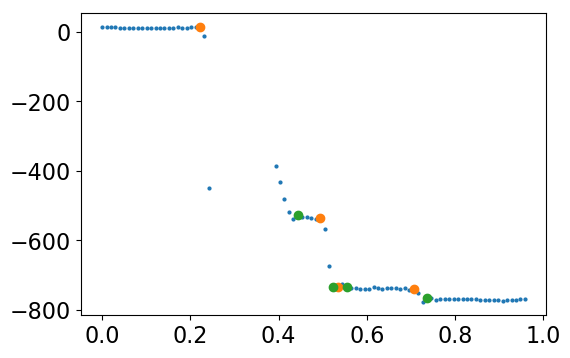

In [104]:
# trial = random.sample(list(choices_com.index), 1)
traj = dynamics_com.loc[trial]
get_com_lag_v2(traj)
# plt.plot(traj.timestamp, traj.eye_x, marker='o', ls='', ms=2)


[28] [42]


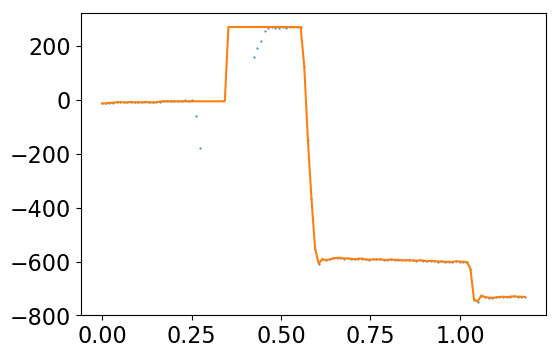

In [19]:
choices = choices_2
dynamics = dynamics_2
choices_com = choices[choices.is_com]
dynamics_com = dynamics.loc[choices.is_com].join(choices_com.idx_midline_d)
trial = random.sample(list(choices_com.index), 1)
traj = dynamics_com.loc[trial]
plt.plot(traj.timestamp, traj.eye_x.values, '.', ms=1)
plt.plot(traj.timestamp, remove_nans(traj.eye_x.values))
# print(traj.eye_x)